
# Determine MLD
This section reads in the CTD downcast files and identifies the 0.03 density change to calculate the MLD. THe MLD is then linearly interpolated onto the ship's track.

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

__Load the CTD data:__

In [8]:
ctd.path = './Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx'
log.path = './Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx'

## Read in the data files and convert the excel time
log = read.xlsx(log.path, sheet = 'Data')
ctd = read.xlsx(ctd.path)

In [9]:
calc.mld = function(ctd.path, log.path, delta.rho = 0.1, real.time = TRUE) {
    

    
    ## this section calculates the mld for each cast
    mld = data.frame(time = 0, Lat = 0, Long = 0, mld = 0, Cast = 0)
    #mld.times = c()

    ctd = ctd[ctd$Pressure >= 10,] ## Remove shallow data since mld will be defined as > 10m

    ## Go through each cast and determine the MLD and then save that depth to a table.
    for (i in unique(ctd$Cast)){

        ## Select the relevent density profile
        l = which(ctd$Cast == i)
        rho = ctd$Sigma_00[l]
        if (all(is.na(rho))) {
            rho = ctd$Sigma_11[l]
        }

        if (length(l) > 5) { ## make sure it was a real cast (i.e. more than 10 data points)

            l.log = which(log$Cast == i)[1]  # Which entry is this cast in the ctd log?
            rho.10 = rho[ctd$Pressure[l] == 10]  # density at 10 meters depth

            ll = which.min(abs(rho - (rho.10 + delta.rho)))# What is the closest density to rho10 + 0.03?

            # Save the Data
            mld = rbind(mld, c(ctd$DateTime_GMT[l[1]], log$Lat[l.log], log$Long[l.log], ctd$Pressure[l[ll]], i) )
            #mld.times = c(mld.times, ctd$DateTime_GMT[l[1]])
        }
    }
    if (real.time) {
        mld$time = conv_excel_time(mld$time)
    }
    
    mld = mld[-1,]
    mld
}

__Run the Interpolation:__

In [46]:
## Choose a delta rho from rho.10
#delta.rho = 0.03
#delta.rho = 0.05
delta.rho = 0.1
#delta.rho = 0.125

mld = calc.mld(ctd, log, delta.rho)

---
# SeaSoar

In [47]:
load('RStates/SeaSoar1.MLD (0.1).rdata')
load('RStates/SeaSoar2.MLD (0.1).rdata')
seasoar1$Cast = -1
seasoar2$Cast = -2
colnames(seasoar2) = colnames(mld)
colnames(seasoar1) = colnames(mld)
#mld = rbind(mld, seasoar1)
mld = rbind(mld, seasoar2)

In [27]:
pdf('Output/Input MLD - Calculated MLD.pdf')

plot.map(lon = mld$Long, lat = mld$Lat, main = 'MLD Positions', pch=16,
         col = make.div.pal2(mld$mld, 100, min = 10, max = 50, pal = 'PiYG'), cex=1.3)

points(x = rep(-119, 100), y = seq(34.5,36, length.out = 100), col = get.div.pal(100, pal = 'PiYG'), pch=20, cex=2)
text(rep(-118.7,2), c(34.5, 36), labels = c('10m', '50m'))

dev.off()

png 
  2

In [7]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


---
# Save the results

In [36]:
save(mld, file=paste0('./RStates/mld-smoothed-', delta.rho ,'.rdata'))

In [2]:
load('RStates/mld-0.1.rdata')

---
# Plots

In [42]:
#par(mfrow=c(2,2))
#hist(mld$mld, breaks = 20)

In [6]:
plot.cast = function(ctd, mld, target.time, d.max = 100, save.plots = FALSE, dir = 'Output/') {
    ctd$DateTime_GMT = conv_excel_time(ctd$DateTime_GMT)
    
    cast = ctd$Cast[which.min(as.numeric(difftime(ctd$DateTime_GMT, target.time, units='hours'))^2)]
    name = paste("Cast -", cast)


    if (save.plots) {
        pdf(paste0(dir, 'CTD Profile + MLD-', name, '.pdf'))
    }
    par(mfrow=c(2,2))

    l = which(ctd$Cast == cast)
    plot(ctd$T190C[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Temperature', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$OxymicroM[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='uM Oxygen', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$Sigma_11[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Density', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$Fluor[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Fluorometer', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)
    
    if (save.plots) {
        dev.off()
    }
}

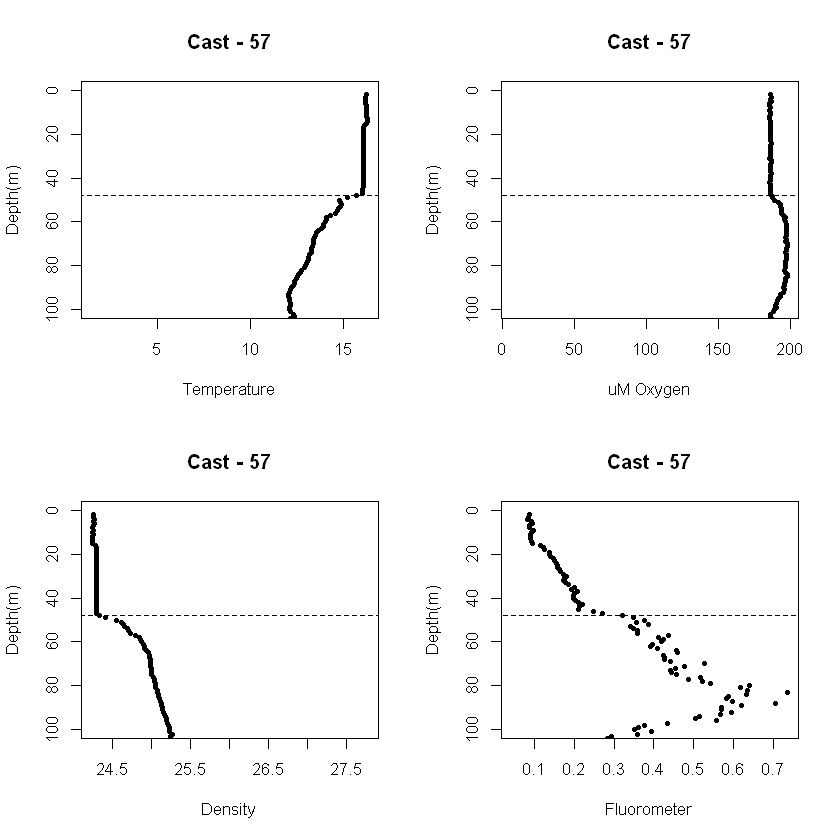

In [7]:
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')
target.time = strptime("2017/06/22 20:05", format="%Y/%m/%d %H:%M", tz='UTC')
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')

plot.cast(ctd, mld, target.time, save.plots = FALSE)

In [11]:
for (i in unique(log$DateTime_GMT)) {
    try({plot.cast(ctd, mld, conv_excel_time(i), save.plots = TRUE, dir = 'Output/CTD/')})
}

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in 

In [31]:
plot.cycle = function(ctd, mld, cycle = 'Cycle1', d.max = 100, save.plots = FALSE, dir = 'Output/') {
    ctd$DateTime_GMT = conv_excel_time(ctd$DateTime_GMT)
    
    l = which(ctd$Cycle == cycle)
    name = paste("Cycle -", cycle)

    if (save.plots) {
        pdf(paste0(dir, 'CTD Cycle Profiles + MLD-', name, '.pdf'))
    }
    par(mfrow=c(2,2))

    cast = unique(ctd$Cast[l])
    plot(ctd$T190C[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Temperature', main=name)
    for (i in cast) {
        lines(c(0,1e3), rep(mld$mld[which(mld$Cast == i)], 2), col='#00000030')
    }

    plot(ctd$OxymicroM[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='uM Oxygen', main=name)
    for (i in cast) {
        lines(c(0,1e3), rep(mld$mld[which(mld$Cast == i)], 2), col='#00000030')
    }
    
    plot(ctd$Sigma_11[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Density', main=name)
    for (i in cast) {
        lines(c(0,1e3), rep(mld$mld[which(mld$Cast == i)], 2), col='#00000030')
    }
    
    plot(ctd$Fluor[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), xlim=c(0,16), ylab='Depth(m)', xlab='Fluorometer', main=name)
    for (i in cast) {
        lines(c(0,1e3), rep(mld$mld[which(mld$Cast == i)], 2), col='#00000030')
    }
    
    if (save.plots) {
        dev.off()
    }
}

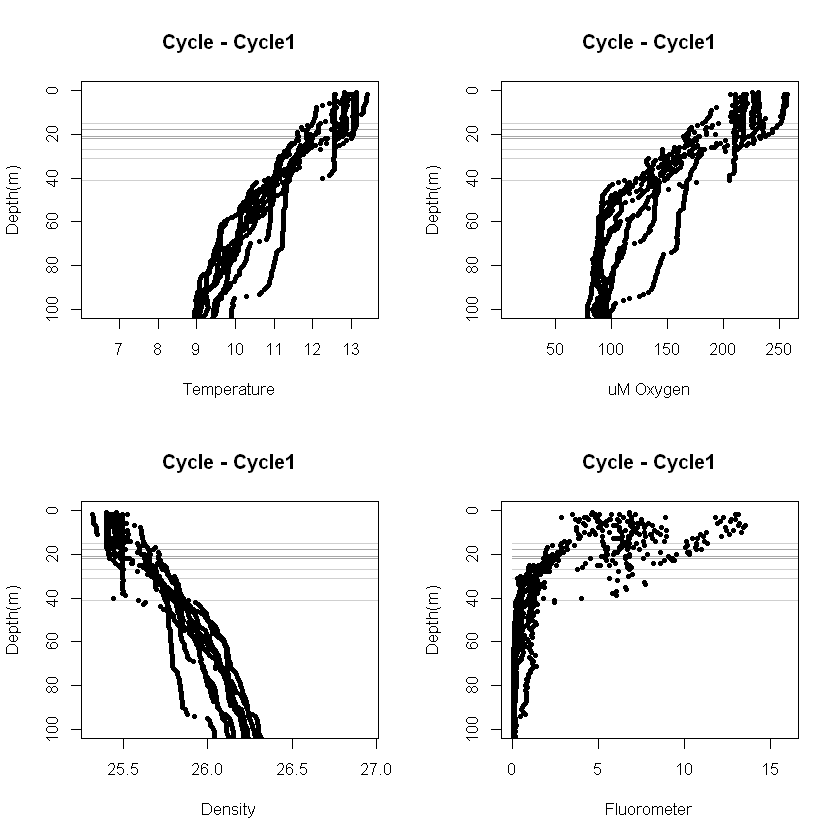

In [32]:
plot.cycle(ctd, mld)

In [33]:
for (i in unique(ctd$Cycle)) {
    plot.cycle(ctd, mld, save.plots = TRUE)
}

In [52]:
load('RStates/ship.final.rdata')

In [87]:
plot.mld = function(ctd, mld, cycle = 'Cycle1', d.max = 100, save.plots = FALSE, dir = 'Output/') {
    ctd$DateTime_GMT = conv_excel_time(ctd$DateTime_GMT)
    
    l = which(ctd$Cycle == cycle)
    name = paste("Cycle -", cycle)

    if (save.plots) {
        pdf(paste0(dir, 'CTD Cycle Profiles + MLD-', name, '.pdf'))
    }

    cast = unique(ctd$Cast[l])
    
    plot(ctd$DateTime_GMT[l], rep(0, length(l)), ylim=c(80,0), col='white', main=cycle, xlab='', ylab='Depth', yaxs='i')
    points(mld$time[mld$Cast %in% cast], mld$mld[mld$Cast %in% cast], pch=16)
    points(ship.data$DT, 8*ship.data$TT-60, col='#0000a312', pch=20, cex=0.3)
    
    if (save.plots) {
        dev.off()
    }
}

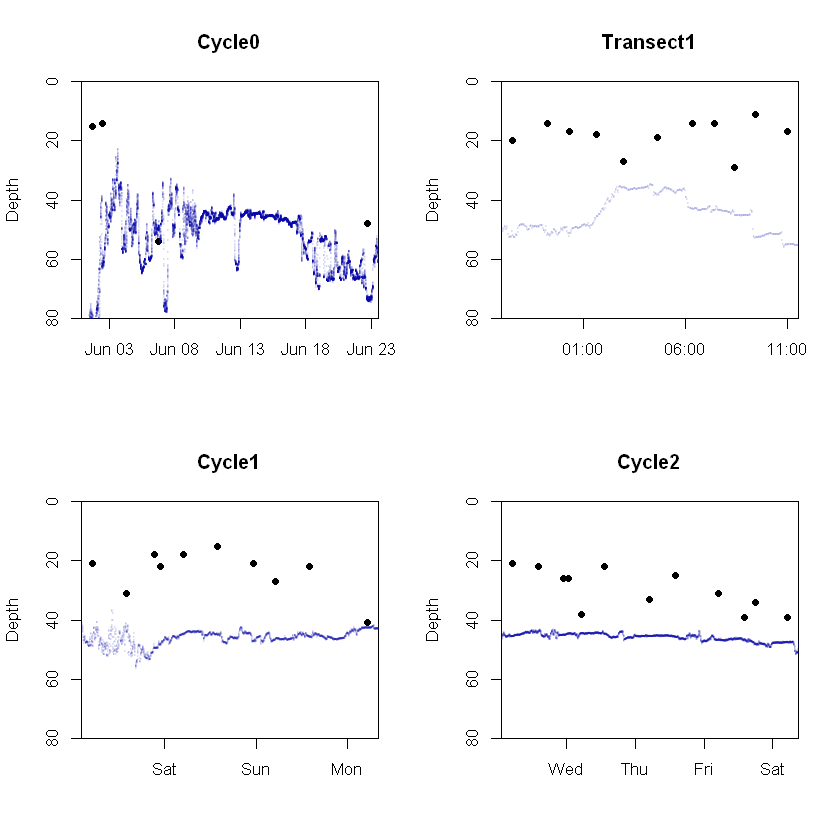

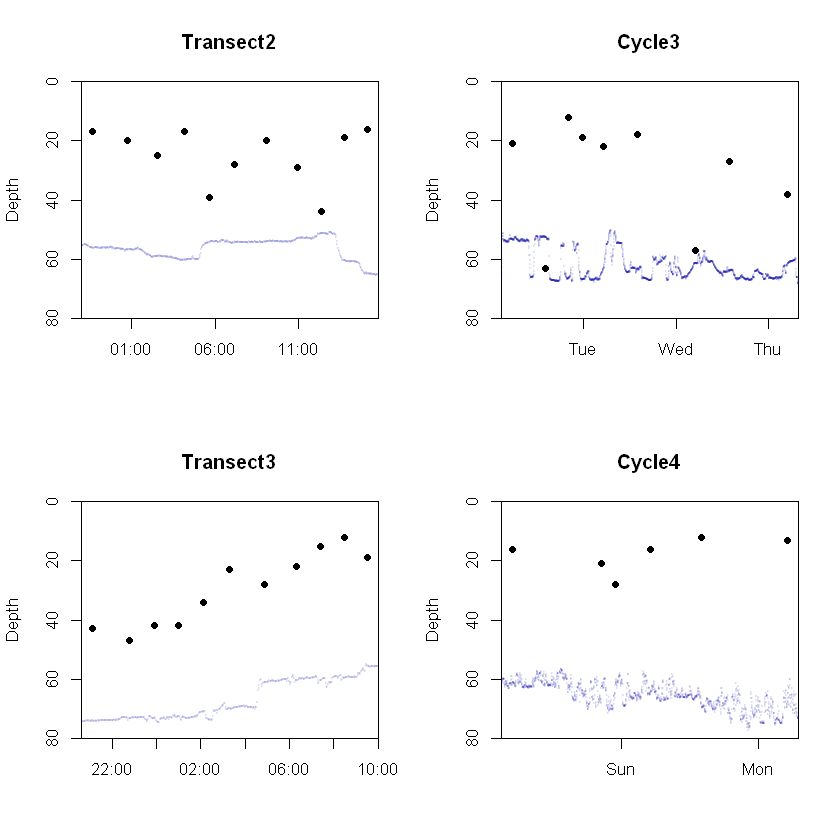

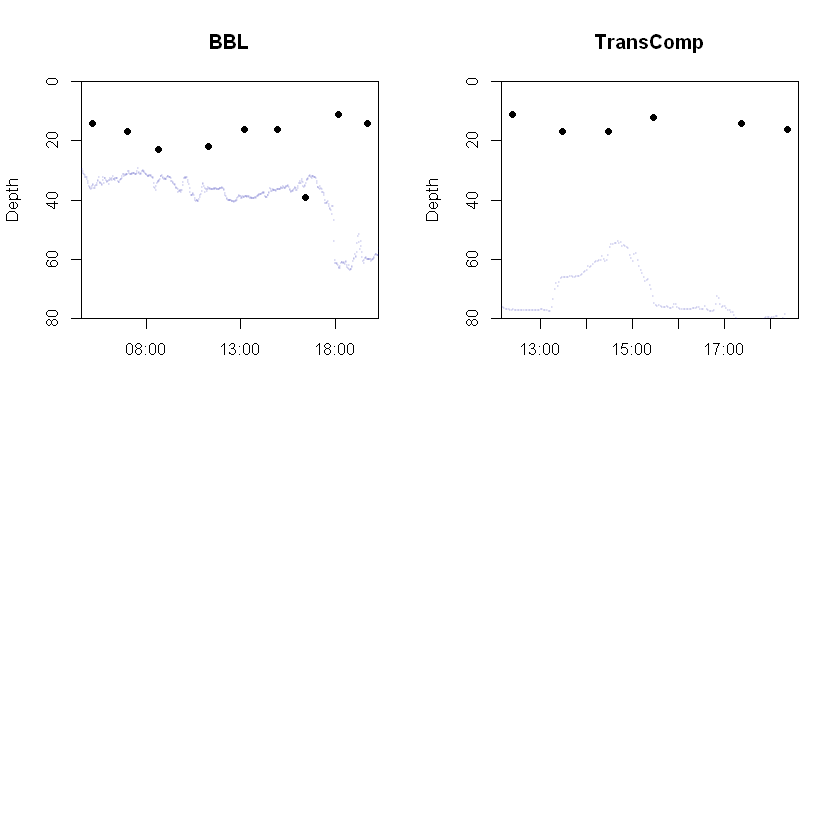

In [90]:
#pdf('Output/MLD Input - MLD and Surface T per Cycle.pdf')

par(mfrow=c(2,2))
for (i in unique(ctd$Cycle)) {
    plot.mld(ctd, mld, cycle = i)
}

#dev.off()

---
# Sensativity Analysis

In [ ]:
## Choose a delta rho from rho.10

mld.3 = calc.mld(ctd, log, delta.rho = 0.03)
mld.5 = calc.mld(ctd, log, delta.rho = 0.05)
mld.10 = calc.mld(ctd, log, delta.rho = 0.10)
mld.125 = calc.mld(ctd, log, delta.rho = 0.125)

In [64]:
evolution.T = function(cycle, temp.mld) {
    l = which(ctd$Cycle == cycle)
    cast.times = conv_excel_time(ctd$DateTime_GMT[l])
    data = data.frame(cast = 0, T = 0)
    
    for (i in 1:length(unique(ctd$Cast[l]))) {
        mlds = temp.mld$mld[which.min(temp.mld$Cast == unique(ctd$Cast[l])[i])]
        
        cast = unique(ctd$Cast[l])[i]
        l.cast = which(ctd$Cast == cast)
        data = rbind(data, c(cast, mean(ctd$T090C[ctd$Pressure[l.cast] < mlds], na.rm = TRUE)))
    }
    data = data[-1,]
    data
}

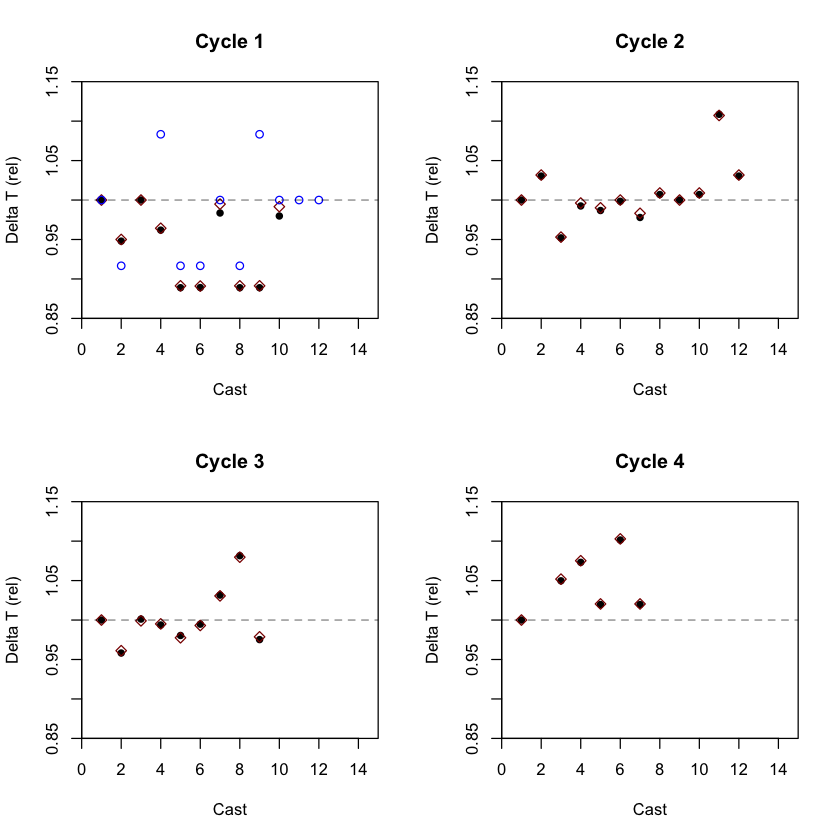

In [69]:

a = evolution.T('Cycle1', mld.3)
b = evolution.T('Cycle2', mld.3)
c = evolution.T('Cycle3', mld.3)
d = evolution.T('Cycle4', mld.3)

#a2 = evolution.T('Cycle1', mld.10)
#b2 = evolution.T('Cycle2', mld.10)
#c2 = evolution.T('Cycle3', mld.10)
#d2 = evolution.T('Cycle4', mld.10)

a2 = evolution.T('Cycle1', mld.125)
b2 = evolution.T('Cycle2', mld.125)
c2 = evolution.T('Cycle3', mld.125)
d2 = evolution.T('Cycle4', mld.125)

par(mfrow=c(2,2))
plot(a$T/a$T[1], ylim = c(.85, 1.15), xlim = c(0,15), xaxs='i', yaxs='i', ylab='Delta T (rel)', xlab='Cast',
     pch=16, main='Cycle 1')
points(a2$T/a2$T[1], pch=5, col='dark red')
lines(c(0,20), c(1,1), lty=2, col='#00000080')

plot(b$T/b$T[1], ylim = c(.85, 1.15), xlim = c(0,15), xaxs='i', yaxs='i', ylab='Delta T (rel)', xlab='Cast',
     pch=16, main='Cycle 2')
points(b2$T/b2$T[1], pch=5, col='dark red')
lines(c(0,20), c(1,1), lty=2, col='#00000080')

plot(c$T/c$T[1], ylim = c(.85, 1.15), xlim = c(0,15), xaxs='i', yaxs='i', ylab='Delta T (rel)', xlab='Cast',
     pch=16, main='Cycle 3')
points(c2$T/c2$T[1], pch=5, col='dark red')
lines(c(0,20), c(1,1), lty=2, col='#00000080')

plot(d$T/d$T[1], ylim = c(.85, 1.15), xlim = c(0,15), xaxs='i', yaxs='i', ylab='Delta T (rel)', xlab='Cast',
     pch=16, main='Cycle 4')
points(d2$T/d2$T[1], pch=5, col='dark red')
lines(c(0,20), c(1,1), lty=2, col='#00000080')

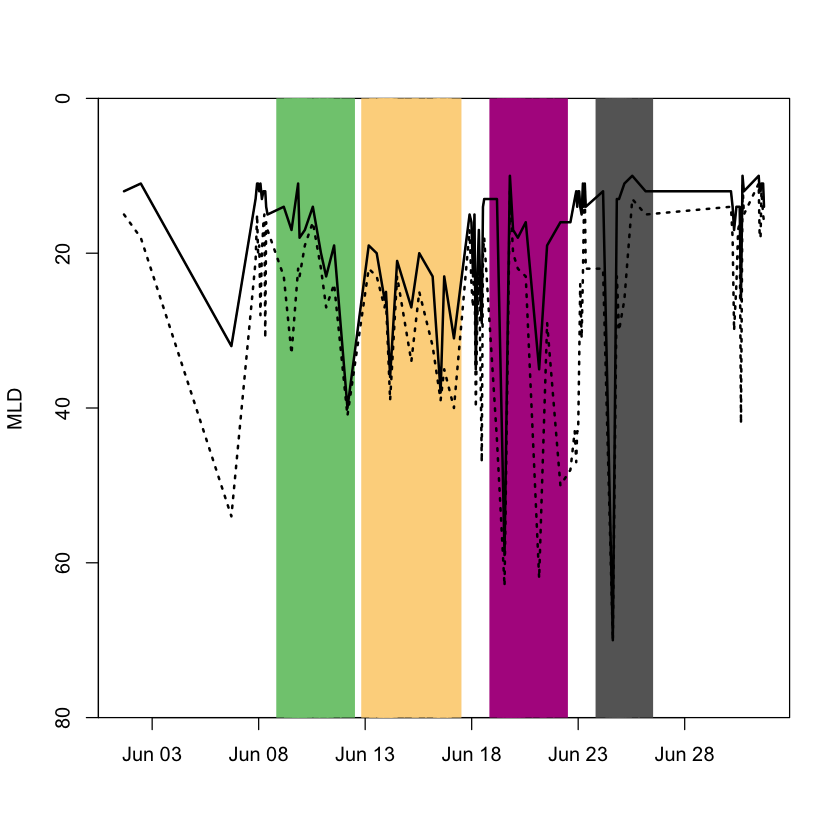

In [90]:
plot(mld.3$time, mld.3$mld, type='l', ylab='MLD', ylim=c(80,0), yaxs='i', xlab='')
for (i in 1:nrow(log)) {
    lines(x = rep(conv_excel_time(log$DateTime_GMT[i]), 2), c(0,100),
          col=get.qual.pal(4)[which(log$Cycle[i] == c('Cycle1', 'Cycle2', 'Cycle3', 'Cycle4'))], lwd=12)
}
lines(mld.3$time, mld.3$mld, lwd=2)
lines(mld.125$time, mld.125$mld, lwd=2, lty=3)

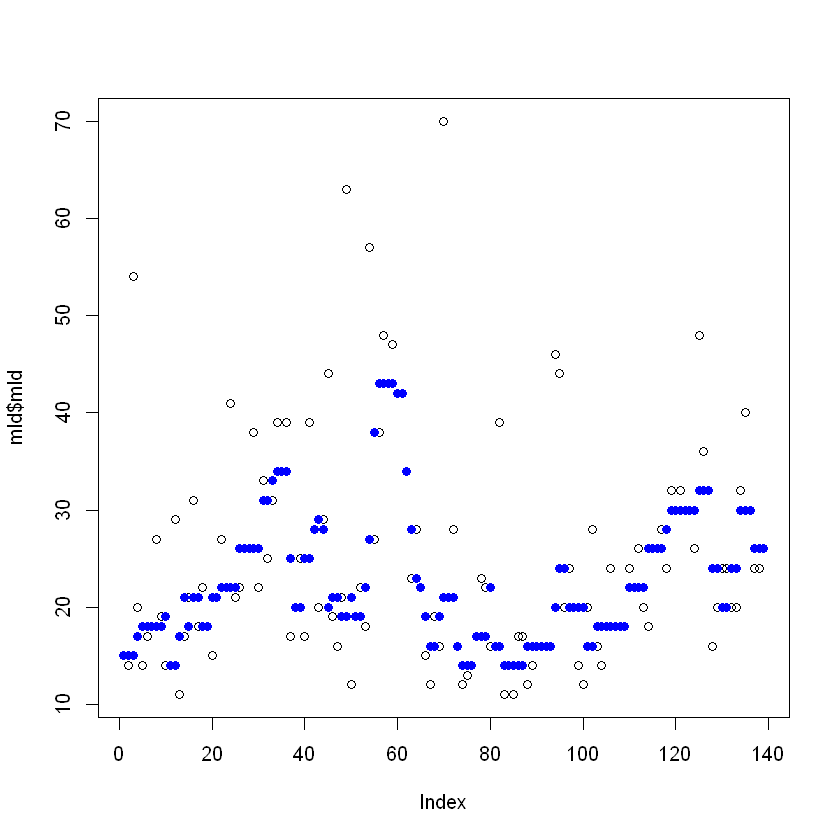

In [33]:
plot(mld$mld)
points(runmed(mld$mld, 5), col='blue', pch=16)

mld$mld = runmed(mld$mld, 5)

In [ ]:
save(mld, )

---
# Sensativity Analysis